# NLP ASSIGNMENT
## Detecting fake news through NLP

In [221]:
#Import required libraries
import pandas as pd
import numpy as np
import itertools

from utils import *
from clf import *

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings("ignore")

In [222]:
#In order to be able to explore the whole DataFrame we have to set the option of maximum number of rows to 5k:
#pd.set_option('display.max_rows',500)
#pd.set_option('max_colwidth',1000)

In [223]:
#Load trainning and test set
train_set=pd.read_csv(filepath_or_buffer='./data/fake_or_real_news_training.csv',sep=',',header=0)
validation_set=pd.read_csv(filepath_or_buffer='./data/fake_or_real_news_test.csv',sep=',',header=0)

# 1. Base Line Model (Without Pre-processing)

## 1.1. DATA EXPLORATION

In [224]:
#Show the structure of the train_set to then evaluate each feature
train_set.head(5)

ID                                              title  \
0   8476                       You Can Smell Hillary’s Fear   
1  10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2   3608        Kerry to go to Paris in gesture of sympathy   
3  10142  Bernie supporters on Twitter erupt in anger ag...   
4    875   The Battle of New York: Why This Primary Matters   

                                                text label   X1   X2  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  NaN  NaN  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  NaN  NaN  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  NaN  NaN  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  NaN  NaN  
4  It's primary day in New York and front-runners...  REAL  NaN  NaN

The target variable is label. Label should have only 2 values:
* Fake
* Real

However it can be seen that initially this is not the case. There are a total of 35 different values for label, which means that **33 values are incorrect**.

In [225]:
n_classes=train_set['label'].value_counts().count()
print(f'The total number of values under the label column are {n_classes}')

The total number of values under the label column are 35


It seems that the X1 and X2 are mostly empty so we are going to evaluate the missing values in each feature.

In [226]:
# Using the own defined missing_values_table function,features that have missing values and the percentage is summarized
missing_values_table(train_set)

Your selected dataframe has 6 columns.
There are 2 columns that have missing values.


Missing Values  % of Total Values
X2            3997               99.9
X1            3966               99.2

In [227]:
################################################################################
# I would remove this since the pd.value_counts() already provides a histogram #
################################################################################
#np.unique(train_set.label).head()

It seems that the X1 and X2 features have some useful information and that the "label" feature has some mistaken rows. Thus we are going to determine how many rows have a different value than FAKE or REAL. 

In [228]:
len(train_set[~((train_set.label == 'FAKE') | (train_set.label == 'REAL'))])

33

## 1.2.DATA CLEANING


### Fixing incorrect rows

To understand what is happening with those 33 rows that have errors in the label we are going to separate them from the train_set to then do some EDA.

In [229]:
incorrect_rows = train_set[~((train_set.label == 'FAKE') | (train_set.label == 'REAL'))]
incorrect_rows
#BREO: I think all these have in common that they have underheader, so they have title, subtitle and text

ID                                              title  \
192     599                 Election Day: No Legal Pot In Ohio   
308   10194  Who rode it best? Jesse Jackson mounts up to f...   
382     356                     Black Hawk crashes off Florida   
660    2786     Afghanistan: 19 die in air attacks on hospital   
889    3622  Al Qaeda rep says group directed Paris magazin...   
911    7375  Shallow 5.4 magnitude earthquake rattles centr...   
1010   9097                   ICE Agent Commits Suicide in NYC   
1043   9203        Political Correctness for Yuengling Brewery   
1218   1602  Poll gives Biden edge over Clinton against GOP...   
1438   4562                  Russia begins airstrikes in Syria   
1493   4748                                         Trump &amp   
1591   3508                         Belgian police mount raids   
1630   7559  STATE OF GEORGIA FIRES PASTOR BECAUSE OF HIS F...   
1716   3634      The Latest On Paris Attack: Manhunt Continues   
1900   8470  The Amish In America Commit Their Vote To Dona...   
1968   6404  #BREAKING: SECOND Assassination Attempt On Tru...   
2176  10499  30th Infantry Division: “Work Horse of the Wes...   
2184      9               Planned Parenthood’s lobbying effort   
2493  10492  TOP BRITISH GENERAL WARNS OF NUCLEAR WAR WITH ...   
2549  10138                Inside The Mind Of An FBI Informant   
2880   4953       Gary Johnson Avoids Typical Third-Party Fade   
2920    496                   Nearly 300K New Jobs In February   
3010   5741                                      Why Trump Won   
3069   4131    Jesse Matthew charged in Hannah Graham's murder   
3110   8748      WATCH: Mass Shooting Occurs During #TrumpRiot   
3130   6717                   Jim Rogers: It’s Time To Prepare   
3210   2943              Islamic State admits defeat in Kobani   
3372   5248        Clinton Cries Racism Tagging Trump with KKK   
3478   3624           Suspects In Paris Magazine Attack Killed   
3537   6268  Chart Of The Day: Since 2009—–Recovery For The 5%   
3578   2738                              Ted Cruz launches bid   
3649   4025  State Dept. IDs 2 Americans killed in Nepal quake   
3706   9954  Incredible smoke haze seen outside NDTV office...   

                                                   text  \
192                         Democrats Lose In The South   
308                    Leonardo DiCaprio to the rescue?   
382                                 human remains found   
660                                  U.S. investigating   
889                            US issues travel warning   
911                            shakes buildings in Rome   
1010   Leaves Note Revealing Gov’t Plans to Round-up...   
1043                    What About Our Opioid Epidemic?   
1218                               VP meets with Trumka   
1438             U.S. warns of new concerns in conflict   
1493   Clinton Were Very Convincing...on How Lousy t...   
1591       prosecutors acknowledge missed opportunities   
1630       GOVERNMENT DIDN’T “APPROVE” BIBLICAL SERMONS   
1716                       Brothers Were On No-Fly List   
1900   Mathematically Guaranteeing Him A Presidentia...   
1968                       Suspect Detained (LIVE BLOG)   
2176                             The Big Picture TV-211   
2184                     pay raises for federal workers   
2493                    “THE END OF LIFE AS WE KNOW IT”   
2549          Terri Linnell Admits Role As Gov’t Snitch   
2880                    Best Polling Since Perot in ‘92   
2920                   Unemployment Dips To 5.5 Percent   
3010                                   Why Clinton Lost   
3069                   DA will not pursue death penalty   
3110                              Media Ignores (Video)   
3130   Economic And Financial Collapse Imminent (VIDEO)   
3210                                  blames airstrikes   
3372                              Trump Says 'She Lies'   
3478             Market Gunman And 4 Hostages Also De

It seems that the error happened when reading the data because of some delimiters used for the text, dividing it into two features when it should have been just one. 

Thus, we are going to concatenate those rows and assign the result to the variable text, and assign the proper labels that are stored in X1 to the label variable.

Finally, we are going to print the final result to evaluate if the error has been corrected.

In [230]:
incorrect_rows.text = incorrect_rows.text + incorrect_rows.label
incorrect_rows.label = incorrect_rows.X1

incorrect_rows[~((incorrect_rows.label == 'FAKE') | (incorrect_rows.label == 'REAL'))]

ID                                              title  \
2184     9               Planned Parenthood’s lobbying effort   
3537  6268  Chart Of The Day: Since 2009—–Recovery For The 5%   

                                                   text  \
2184   pay raises for federal workers and the future...   
3537   Stagnation for the 95%Chart Of The Day: Since...   

                                                  label  \
2184  PLANNED PARENTHOOD’S LOBBYING GETS AGGRESSIVE....   
3537                           Stagnation for the 95%     

                                                     X1    X2  
2184  PLANNED PARENTHOOD’S LOBBYING GETS AGGRESSIVE....  REAL  
3537                           Stagnation for the 95%    FAKE

It seems that there are still two rows with errors which labels are in X2, thus we are going to assign the corrected rows in a variable, to then assign the incorrect rows to another variable where we will assign the correct label. Finally, we will concatenate both variables into a single variable and evaluate if the labels have been fixed.

In [231]:
#  Fixing the remaining rows with errors
corrected_rows = incorrect_rows[((incorrect_rows.label == 'FAKE') | (incorrect_rows.label == 'REAL'))]
incorrect_rows = incorrect_rows[~((incorrect_rows.label == 'FAKE') | (incorrect_rows.label == 'REAL'))]

incorrect_rows.label = incorrect_rows.X2

corrected_rows = pd.concat([corrected_rows,incorrect_rows],ignore_index=True)
np.unique(corrected_rows.label)

array(['FAKE', 'REAL'], dtype=object)

All the wrong labels have been corrected, thus we are going to filter the train_set just with the correct rows to then concatenate it with the corrected ones. Finally, we are going to filter the X1 and X2 columns as they do not have any useful information anymore.

In [232]:
# Subsetting the train_set to eliminate the rows with errors to then concatenate it with the fixed ones
train_set = train_set[((train_set.label == 'FAKE') | (train_set.label == 'REAL'))]
train_set = pd.concat([train_set,incorrect_rows],ignore_index=True)

# Subsetting the train_set to not work with the features X1 and X2 as they are 100% empty after fixing the
# rows with errors
train_set = train_set[["ID","title","text","label"]]

In [233]:
np.unique(train_set.label)

array(['FAKE', 'REAL'], dtype=object)

### Target variable distribution on trainning set

Once the dataset is cleaned, it is necessary to check the proportion of the different values of the target variable to make sure it is a balanced dataset. As depicted below, the **dataset is balanced** regarding the target variable.

In [234]:
calculate_target_proportion(train_set)

FAKE:  1991 instances    50.2%
REAL:  1977 instances    49.8%


## 1.3. Extracting and training data

### Defining train and test set
Once the dataset has been cleaned is time to separate the labels and prepare the training and test set

In [15]:
# Set independent and dependent variables x and y
x = train_set.text
y = train_set.label

# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=198374)

### Building Vectorized Classifiers
In order to determine if the words and tokens in the articles have a discriminative power to determine if the news are FAKE or REAL CountVectorizer (Bag of Words) and TfidfVectorizer will be used.

In order to elminate the words that appear in more than 70% of the articles (no discriminative power) the parameter max_df of the TfidfVectorizer will be set to 0.7. Additionaly, the stop_words parameter will be added to the CountVectorizer function to remove them due to the same reason. 

#### CountVectorizer

In [16]:
# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the training data 
count_train = c.fit_transform(X_train) 

# Transform the test set 
count_test = count_vectorizer.transform(X_test)

#### TfidfVectorizer

In [17]:
# Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7) 

# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

#### Results Analysis

In [18]:
# Get the feature names of `tfidf_vectorizer` 
print(tfidf_vectorizer.get_feature_names()[-10:])
#print(tfidf_vectorizer.get_feature_names())

# Get the feature names of `count_vectorizer` 
print(count_vectorizer.get_feature_names()[:10])
#print(count_vectorizer.get_feature_names())

['ź50', 'ελληνικά', 'октября', 'русский', 'эa', 'эin', 'эthe', 'яркий', 'عربي', 'ยงade']
['00', '000', '0000', '00000031', '0002', '000billion', '000km', '001', '003', '004']


As it can be seen there is still a lot of noise in the dataset, thus the pre-processing step will be run iteratively until a sort of clean dataset is obtained.

## 1.4. Modelling

### Confusion Matrix
Firstly, a function to plot the confusion matrix of the models will be implemented due to the importance that false positives have in Fake News analysis, as it may be better not to classify a Real News as Fake. This function is defined in the **[utils.py](./utils.py)** file as **plot_confusion_matrix**.

We are going to try several models over the **TfIdf** and **TF(Bag-of-words)** approach to determine the one with the highest performance, then we are going to work on the hyperparameter tunning and cross validation to try to improve its value.

### Naive Bayes
The first model that will be tested is the Naive Bayes classifier which is the most common model used for NLP tasks.

In [20]:
# Model definition
clf = MultinomialNB() 

#### Naive Bayes performance with TfIdf

accuracy:   0.811


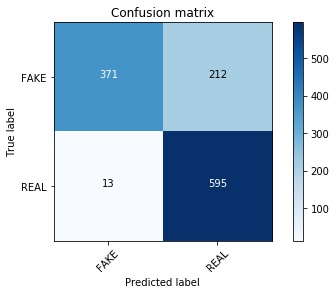

In [21]:
clf.fit(tfidf_train, y_train)
pred = clf.predict(tfidf_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

#### Naive Bayes performance with Bag-of-words

accuracy:   0.882


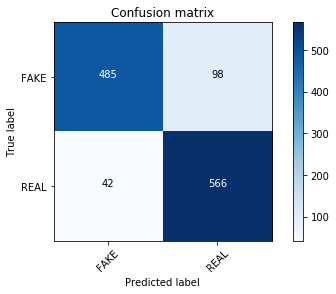

In [22]:
clf.fit(count_train, y_train)
pred = clf.predict(count_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

### Pasive Agressive Classifier

In [23]:
linear_clf = PassiveAggressiveClassifier(n_iter=50)

#### Pasive Aggresive Classifier performance with TfIdf

accuracy:   0.917


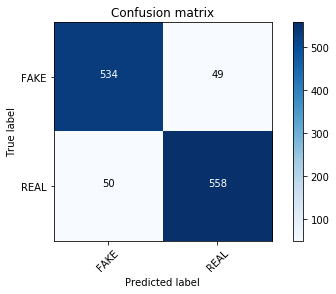

In [24]:
linear_clf.fit(tfidf_train, y_train)
pred = linear_clf.predict(tfidf_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

#### Pasive Aggresive Classifier performance with Bag-of-words

accuracy:   0.871


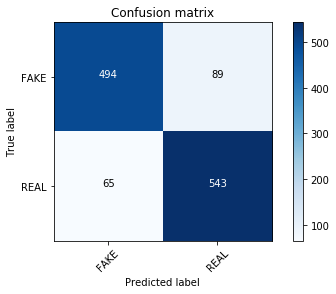

In [25]:
linear_clf.fit(count_train, y_train)
pred = linear_clf.predict(count_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

### MaxEnt (Logistic Regression) Classifier
...

In [26]:
max_ent = LogisticRegression()

#### MaxEnt Classifier performance with TfIdf

accuracy:   0.895


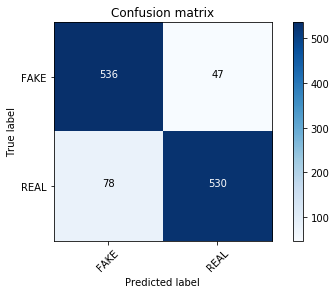

In [27]:
max_ent.fit(tfidf_train, y_train)
pred = max_ent.predict(tfidf_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

#### MaxEnt Classifier performance with Bag-of-words

accuracy:   0.895


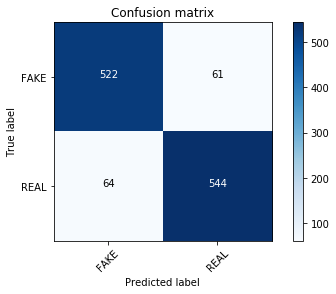

In [28]:
max_ent.fit(count_train, y_train)
pred = max_ent.predict(count_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

### Support Vector Machine Classifier
...

In [29]:
svc_clf = SVC()

#### SVM Classifier performance with TfIdf

accuracy:   0.490


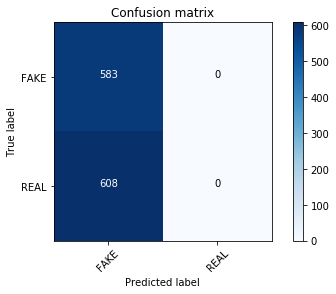

In [30]:
svc_clf.fit(tfidf_train, y_train)
pred = svc_clf.predict(tfidf_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

#### SVM Classifier performance with Bag-of-words

accuracy:   0.732


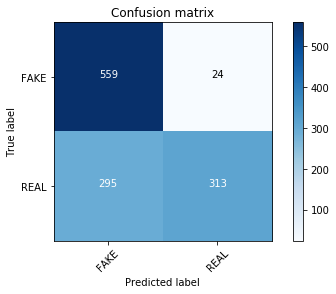

In [31]:
svc_clf.fit(count_train, y_train)
pred = svc_clf.predict(count_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

## Model Tunning
The model with the best performance was the Passive Aggressive Classifier over the TfIdf vectorizer. Thus, the following steps will try to optimize the hyperparameters and apply cross-validation to determine stability of the model.

### Building a Pipeline

In [32]:
# Split the dataset into train and test set (hold-out)
X_train, X_test= tfidf_train, tfidf_test

# Set the parameters by cross-validation
tuned_parameters = [{'n_iter': [5, 50, 200, 1000], 'random_state':[3457]}]

scores = ['recall', 'precision']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(PassiveAggressiveClassifier(), tuned_parameters, cv=10,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")#Cambiamos full development test por train_set
    print("The scores are computed on the full evaluation set.")#Cambiamos full evaluation set por test within the train set
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'n_iter': 5, 'random_state': 3457}

Grid scores on development set:

0.922 (+/-0.030) for {'n_iter': 5, 'random_state': 3457}
0.921 (+/-0.028) for {'n_iter': 50, 'random_state': 3457}
0.921 (+/-0.028) for {'n_iter': 200, 'random_state': 3457}
0.921 (+/-0.028) for {'n_iter': 1000, 'random_state': 3457}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

        FAKE       0.91      0.91      0.91       583
        REAL       0.92      0.92      0.92       608

   micro avg       0.92      0.92      0.92      1191
   macro avg       0.92      0.92      0.92      1191
weighted avg       0.92      0.92      0.92      1191


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'n_iter': 5, 'random_state': 3457}

Grid scores on develo

# 2. Improved model with Preprocessing

Now the influence of preprocessing is going to be analysed. For this reason some cleaning and preprocessing steps are going to be performed. 

## 2.1. Data Cleansing


## DATA PRE-PROCESSING

Exploring the training_set it can be noticed that in the pre-processing step we need to deal with:
* **New lines** are started with the **"\n"** character
* **Paragraphs** are initiated with  **"\n\n"** character
* @ symbols, Do we process them?
* '•','©',':','>>' symbols must be deleted for the purpose of classifying
* Stop words must be removed (for classification purposes)

### Normalization
From the exploratory part, the following normalization process must be handled:
* Capital letters to lower case
* Lemmatization

### Words longer than 30 letters (To be removed as soon as checking if word belongs to English is finished)

According to the following reference: [What is the longest English word?](https://en.oxforddictionaries.com/explore/what-is-the-longest-english-word/ ), the maximum length is 29 letters. So anything higher than that is not a word. Delete or use as feature?

In [45]:
features=count_vectorizer.get_feature_names()

In [46]:
over_30=[feature for feature in features if (len(feature)>=30)]
over_30[:5],over_30[-5:]

(['0h4at2yetra17uxetni02ls2jeg0mty45jrcu7mrzsrpcbq464i',
  '0txrbwvobzz4fi5nksw6k5a6cxzbb3juxthmdiz93cby8gvrqiypzhajvjnt2',
  '12hdlgeeua87t2ju8m4tbro247yj5u2tvp',
  '12sso1zj2bbdguiraddmamlnets7oc1',
  '1bjxt3uhim5fqn93gb0hkxakuarz99d7xcitzftye'],
 ['vsk5kjio2gonjimily9mdhaws2ixhhtv54fhvzpkdyzuqtxkwh2',
  'why_hillary_won_t_unleash_wwiii_',
  'xddctwndz32dvkjrouuac9z2t6ve36lsyyjuzcc2ntg6uir',
  'xr9tij32vguimohq94xyqajonydeghb5u5b5p',
  'ykw4lcmtlfe32kys5odreupsv5zwvgl9sz'])

In [51]:
print(f'There are {len(over_30)} features with length larger than 30')

There are 91 features with length larger than 30


### Words not belonging to english

Our dataset has news only in English; however, some news in our data sets have words in other languages, so is there any way to detect those words which do not belong to English?  

For this purpose let's consider the following sentence:

In [218]:
my_list=word_tokenize('This is the ~ worst sentence 文本 Obama & wrote SiNcE my primo de Barcelona wnet to @ Madrid! , Chicago , Washington , Russia , Romania, 北京.So, Idafen decided to phone Trump',language='english')
my_list[-5:]

['Idafen', 'decided', 'to', 'phone', 'Trump']

***OPTION 1: NLTK Corpus***

We can try to use all the words in the **nltk corpus** and consider them as the all the existing vocabulary of the English language...

In [209]:
def word_in_corpus(words):
    '''Function that removes all non-English words from an input list
    :input: list of tokenized words
    :output: string with only words in English
    '''
    from nltk.corpus import words as corpus_dictionary
    
    news_string=''
    for word in words:
        if word.lower() in corpus_dictionary.words():
            news_string+=' '+word.lower()
    return news_string

In [210]:
word_in_corpus(my_list)

' this is the worst sentence wrote since my de barcelona to russia so decided to phone trump'

If the corpus is used, names of entities and special characters will not be considered as English, so using this function would elminate too much data.

**_OPTION 2: External Dictionary_**

We can also try to use complete dictionaries that include some names of entities, completing it with special punctuation characters trying to address above issues:

In [211]:
import json
from string import punctuation
set(punctuation)   

def words_in_dictionary(words):
    collection=json.load(open('words_dictionary.json'))
    
    news_string=''
    for word in words:
        if word.lower() in collection:
            news_string+=' '+word.lower()
    return news_string    
    

In [212]:
words_in_dictionary(my_list)

' this is the worst sentence wrote since my primo de barcelona to madrid chicago washington russia so decided to phone trump'

**_OPTION 3: PyDictionary Package_**

In [213]:
def pydictionary_check(input_list):
    '''This function takes a list of word and determines if it exists in English based on PyDictionary package
        If it exists, it returns the word, otherwise it pass the word'''
    string=''
    dict=PyDictionary()
    for word in input_list:
        if dict.meaning(word) is not None:
            string+=' '+word
    return string

In [216]:
output=pydictionary_check(my_list)
output

' is worst sentence Obama & wrote primo de Barcelona Madrid Chicago Washington Russia Romania So decided phone Trump'

It can be seen that PyDictionary does not include the **stop words** but it is very powerfull for recognicing names (Sorry **Idafén** is still not famous).  
So an alternative is to unify the power of both solutions.

**_OPTION 4: Conbine Option 2 and 3_**

In [219]:
import json
from string import punctuation
set(punctuation)   

def complete_check(words):
    
    collection=json.load(open('words_dictionary.json'))
    dict=PyDictionary()
    news_string=''
    for word in words:
        
        #Check if it is in the dictionary
        if word.lower() in (collection or set(punctuation)):
            news_string+=' '+word.lower()
        
        #Check in PyDictionary
        else:
            if dict.meaning(word) is not None:
                news_string+=' '+word
            
    return news_string   

In [220]:
complete_check(my_list)

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range


' this is the worst sentence Obama & wrote since my primo de barcelona to madrid chicago washington russia Romania decided to phone trump'

Let's see the performance of our model introducing this "English words detection" step:

In [236]:
def non_english_words_in_df(df,label=[1,2]):
    '''Function that reads all the rows of a dataframe en detect non-existing words in English'''
    '''For dev: first create a new column to compare the result, when sure, overwrite the column'''
    for column in label:
    # Every loop in i is a new row in the dataframe
        for i in range(df.shape[0]):
            # tokenize each row
            text_list = word_tokenize(str(df.iloc[i, column]), language='english')


            if column == 1:
                stamp = 'title_english'
            elif column == 2:
                stamp = 'text_english'

            df.at[i, stamp] = complete_check(text_list)
            text_list = []

    return df

In [237]:
train_set_english=train_set.copy(deep=True)

In [ ]:
%%time
non_english_words_in_df(train_set_english)

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list index out of range
Error: The Following Error occured: list

In [ ]:
# Set independent and dependent variables x and y
x = train_set_english.text_english
y = train_set_english.label

# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=198374)

# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(lowercase=True,max_df=0.7)

# Fit and transform the training data 
count_train = count_vectorizer.fit_transform(X_train) 



# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the training data 
count_train = count_vectorizer.fit_transform(X_train) 

# Transform the test set 
count_test = count_vectorizer.transform(X_test)



# Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7) 

# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)


classifiers(count_train,count_test,tfidf_train,tfidf_test,y_train, y_test)

In [55]:
#https://pypi.org/project/PyDictionary/
#'Download a corpus', if word in corpus, then is english, otherwise not english.
#REMEMBER THE 1ST TIME: ! pip install PyDictionary
from PyDictionary import PyDictionary

In [56]:
dict=PyDictionary()

In [61]:
dict.meaning('Gandhi')

{'Noun': ['daughter of Nehru who served as prime minister of India from 1966 to 1977 (1917-1984',
  "political and spiritual leader during India's struggle with Great Britain for home rule; an advocate of passive resistance (1869-1948"]}

In [ ]:
def english_words(word):
    '''This function takes a word and determines if it exist in English'''
    
    dict=PyDictionary()
    output=dict.meaning(word)
    return output

In [ ]:
error_message='The Following Error occured'
if type(english_words('heo'))=='NoneType':
    print('No english word')

## 2.2. Text Normalization
### Case Sensitive

Both, CountVectorizer and TfidfVectorizer functions have a parameter called **'lowercase'** which deals with the case sensitive problem. However, as it will be presented below, **lower case** is an issue that needs to be handle **during LEMMATIZATION** 

### Lemmatization

Another normalization step is to perform lemmatization to obtain the lemma of the words. This in some way is reducing the number of features, as some words that were different (go, going, went) now will be only one word (go). For such purpose a function called **lemmatizer** was created to perform such operation in the title and text columns of our dataframe.

In [ ]:
train_set_2=train_set.copy(deep=True)

In [ ]:
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

**Lemmatizer curiosity**  
If the word is lowercase, the lematizer works well:

In [ ]:
lower_case_list=['cats','dogs','went','found','women']
for word in lower_case_list:
    print(word+' --> '+str( WordNetLemmatizer().lemmatize(word,pos='v')))

However, if capital letters are used, the lemmatizer does not work so well:

In [ ]:
upper_case_list=['Cats','Dogs','Went','Found','Women']
for word in upper_case_list:
    print(word+' --> '+str( WordNetLemmatizer().lemmatize(word,pos='v')))

Therefore, we need to **convert to lower case every word before lemmatizing**.

In [ ]:
%%time
wordnet_lemmatizer(train_set_2)

In [ ]:
# Set independent and dependent variables x and y
x = traisext_wordnet_lemmatized
y = train_set_2.label

# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=198374)

In [ ]:
# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(lowercase=True,max_df=0.7)

# Fit and transform the training data 
count_train = count_vectorizer.fit_transform(X_train) 

In [ ]:
len(count_vectorizer.get_feature_names())

In [ ]:
# Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(lowercase=True,stop_words='english', max_df=0.7) 

# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [ ]:
classifiers(count_train,count_test,tfidf_train,tfidf_test,y_train, y_test)

In [ ]:
# Split the dataset into train and test set (hold-out)
X_train, X_test= tfidf_train, tfidf_test

# Set the parameters by cross-validation
tuned_parameters = [{'n_iter': [5, 50, 200, 1000], 'random_state':[3457]}]

scores = ['recall', 'precision']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(PassiveAggressiveClassifier(), tuned_parameters, cv=10,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# 3. Improved Model (POS tagging with ngrams)

In [22]:
train_set_3=train_set.copy(deep=True)
train_set_3

ID                                              title  \
0      8476                       You Can Smell Hillary’s Fear   
1     10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2      3608        Kerry to go to Paris in gesture of sympathy   
3     10142  Bernie supporters on Twitter erupt in anger ag...   
4       875   The Battle of New York: Why This Primary Matters   
5      6903                                        Tehran, USA   
6      7341  Girl Horrified At What She Watches Boyfriend D...   
7        95                  ‘Britain’s Schindler’ Dies at 106   
8      4869  Fact check: Trump and Clinton at the 'commande...   
9      2909  Iran reportedly makes new push for uranium con...   
10     1357  With all three Clintons in Iowa, a glimpse at ...   
11      988  Donald Trump’s Shockingly Weak Delegate Game S...   
12     7041  Strong Solar Storm, Tech Risks Today | S0 News...   
13     7623       10 Ways America Is Preparing for World War 3   
14     1571                   Trump takes on Cruz, but lightly   
15     4739                         How women lead differently   
16     7737  Shocking! Michele Obama & Hillary Caught Glamo...   
17     8716  Hillary Clinton in HUGE Trouble After America ...   
18     3304  What's in that Iran bill that Obama doesn't like?   
19     3078  The 1 chart that explains everything you need ...   
20     2517  The slippery slope to Trump’s proposed ban on ...   
21    10348  Episode #160 – SUNDAY WIRE: ‘Hail to the Deplo...   
22      778  Hillary Clinton Makes A Bipartisan Appeal on S...   
23     3300  New Senate majority leader’s main goal for GOP...   
24     6155              ‘Inferno’ and the Overpopulation Myth   
25      636  Anti-Trump forces seek last-ditch delegate revolt   
26      755  Sanders Trounces Clinton in W. Va. -- But Will...   
27      626  Donald Trump Is Changing His Campaign Slogan t...   
28      691  Pure chaos: Donald Trump’s campaign management...   
29     5743  Syrian War Report – November 1, 2016: Syrian M...   
...     ...                                                ...   
3938   9752  Russia suggests joint engineering troops’ dril...   
3939   7117  Military Veterans Are Helping To Save Coral Re...   
3940   6161        Trump: Israel is a ray of hope to the world   
3941   2504  Along the migrant trail, pressure grows to clo...   
3942   9466  News: Inspiring: When This Woman Was Feeling T...   
3943   8271  Smart Meter Case Testimony Before the Pennsylv...   
3944   6596  Reporters Stunned to Learn Trump Fans Lining U...   
3945   8170  IOWA FARMER CLAIMS BILL CLINTON HAD SEX WITH C...   
3946   3216  Republicans Reject Calls on Guantanamo Bay Clo...   
3947   4201  GOP elites are now resigned to Donald Trump as...   
3948   4192  Trump's Indiana win raises unsettling question...   
3949   9850  Cypriot leaders to continue talks in November: UN   
3950   3598  Freed Al Qaeda operative floated as part of pr...   
3951  10244        This Viral Video Has Hillary Running Scared   
3952   5837  Comment on After Sweeping Election, First Thin...   
3953   2787  Obama to keep 5,500 US troops in Afghanistan b...   
3954   9229  Family Remembers Queens Sucker Punch Victim ‘H...   
3955   8556  Black Americans Going For Donald Trump In Reco...   
3956   2966      Success against ISIS requires a team of teams   
3957   1433  The Edge: Cruz, Trump get media attention post...   
3958    328  NY police investigate possible sighting of esc...   
3959   4723  “He and I Haven’t Spoken”: Trump and Pence Are...   
3960   7927  FBI Director may be sacked for intrusion into ...   
3961    802                 Fault lines: GOP civil war deepens   
3962   1026  Clinton, under fire for oil and gas donations,...   
3963   1459  His rivals are saying the same thing in differ...   
3964   5366  The Genocide of Indigenous Peoples in North Am...   
3965   9673                                  Checkmating Obama   
3966      9               Planned Parenthood’s lo

In [24]:
%%time
#Create the Ngram tagger
ngram_tagger=ngram_pos_tagger()

Wall time: 52.4 s


In [25]:
%%time
#Once the ngram POS tagger is ready, transform our dataframe into the lemmatized version
ngram_lemmatizer(train_set_3,tagger=ngram_tagger)

Wall time: 52.9 s


ID                                              title  \
0      8476                       You Can Smell Hillary’s Fear   
1     10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2      3608        Kerry to go to Paris in gesture of sympathy   
3     10142  Bernie supporters on Twitter erupt in anger ag...   
4       875   The Battle of New York: Why This Primary Matters   
5      6903                                        Tehran, USA   
6      7341  Girl Horrified At What She Watches Boyfriend D...   
7        95                  ‘Britain’s Schindler’ Dies at 106   
8      4869  Fact check: Trump and Clinton at the 'commande...   
9      2909  Iran reportedly makes new push for uranium con...   
10     1357  With all three Clintons in Iowa, a glimpse at ...   
11      988  Donald Trump’s Shockingly Weak Delegate Game S...   
12     7041  Strong Solar Storm, Tech Risks Today | S0 News...   
13     7623       10 Ways America Is Preparing for World War 3   
14     1571                   Trump takes on Cruz, but lightly   
15     4739                         How women lead differently   
16     7737  Shocking! Michele Obama & Hillary Caught Glamo...   
17     8716  Hillary Clinton in HUGE Trouble After America ...   
18     3304  What's in that Iran bill that Obama doesn't like?   
19     3078  The 1 chart that explains everything you need ...   
20     2517  The slippery slope to Trump’s proposed ban on ...   
21    10348  Episode #160 – SUNDAY WIRE: ‘Hail to the Deplo...   
22      778  Hillary Clinton Makes A Bipartisan Appeal on S...   
23     3300  New Senate majority leader’s main goal for GOP...   
24     6155              ‘Inferno’ and the Overpopulation Myth   
25      636  Anti-Trump forces seek last-ditch delegate revolt   
26      755  Sanders Trounces Clinton in W. Va. -- But Will...   
27      626  Donald Trump Is Changing His Campaign Slogan t...   
28      691  Pure chaos: Donald Trump’s campaign management...   
29     5743  Syrian War Report – November 1, 2016: Syrian M...   
...     ...                                                ...   
3938   9752  Russia suggests joint engineering troops’ dril...   
3939   7117  Military Veterans Are Helping To Save Coral Re...   
3940   6161        Trump: Israel is a ray of hope to the world   
3941   2504  Along the migrant trail, pressure grows to clo...   
3942   9466  News: Inspiring: When This Woman Was Feeling T...   
3943   8271  Smart Meter Case Testimony Before the Pennsylv...   
3944   6596  Reporters Stunned to Learn Trump Fans Lining U...   
3945   8170  IOWA FARMER CLAIMS BILL CLINTON HAD SEX WITH C...   
3946   3216  Republicans Reject Calls on Guantanamo Bay Clo...   
3947   4201  GOP elites are now resigned to Donald Trump as...   
3948   4192  Trump's Indiana win raises unsettling question...   
3949   9850  Cypriot leaders to continue talks in November: UN   
3950   3598  Freed Al Qaeda operative floated as part of pr...   
3951  10244        This Viral Video Has Hillary Running Scared   
3952   5837  Comment on After Sweeping Election, First Thin...   
3953   2787  Obama to keep 5,500 US troops in Afghanistan b...   
3954   9229  Family Remembers Queens Sucker Punch Victim ‘H...   
3955   8556  Black Americans Going For Donald Trump In Reco...   
3956   2966      Success against ISIS requires a team of teams   
3957   1433  The Edge: Cruz, Trump get media attention post...   
3958    328  NY police investigate possible sighting of esc...   
3959   4723  “He and I Haven’t Spoken”: Trump and Pence Are...   
3960   7927  FBI Director may be sacked for intrusion into ...   
3961    802                 Fault lines: GOP civil war deepens   
3962   1026  Clinton, under fire for oil and gas donations,...   
3963   1459  His rivals are saying the same thing in differ...   
3964   5366  The Genocide of Indigenous Peoples in North Am...   
3965   9673                                  Checkmating Obama   
3966      9               Planned Parenthood’s lo

In [38]:
# Set independent and dependent variables x and y
x = train_set_3.text_ngram_lemmatized
y = train_set_3.label

# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=198374)

In [39]:
# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(lowercase=True,max_df=0.7)

# Fit and transform the training data 
count_train = count_vectorizer.fit_transform(X_train) 

CountVectorizer

In [40]:
# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the training data 
count_train = count_vectorizer.fit_transform(X_train) 

# Transform the test set 
count_test = count_vectorizer.transform(X_test)

TfidfVectorizer

In [41]:
# Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7) 

# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)



NAIVE BAYES CLASSIFIER
-------------------------------------
NB with TfIdf accuracy:   0.813
NB with Tf accuracy:   0.882


PASSIVE AGGRESIVE CLASSIFIER
-------------------------------------
Passive Aggresive with TfIdf accuracy:   0.904
Passive Aggresive with Tf accuracy:   0.856


MAXIMUM ENTROPY CLASSIFIER
-------------------------------------
Maximum Entropy with TfIdf accuracy:   0.891
Maximum Entropy with Tf accuracy:   0.895


SVM CLASSIFIER
-------------------------------------
SVM with TfIdf accuracy:   0.490
SVM with Tf accuracy:   0.763


The best model is passive_clf_tfidf with an accuracy of: 0.904


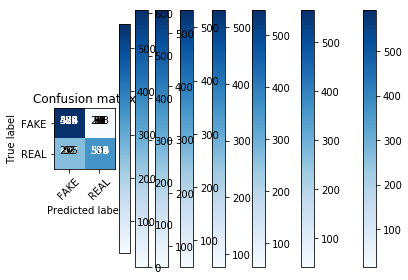

In [42]:
classifiers(count_train,count_test,tfidf_train,tfidf_test,y_train, y_test)

Falta por hacer:
* train con sólo text, sólo title, title+text (Sebastián)-->Usa la función classifiers() en [clf.py](./clf.py) para pasarle los distintos tfidf y tf. En 6 líneas puedes probar todas las combinaciones (text y/o title) con todos los clasificadores que hemos definido en este proyecto.
* cambiar caracteres especiales a 'tags' (Sebastián)

* Introducir NER en la parte de reconocer palabras inglesas (Breo)
* Arreglar función classifiers() para que la confusion matrix aparezca bien (Sebastián)
* Review ngrams function (Breo)✓